Task:

Design a quantum algorithm that when given numbers of range [1,n) and are odd convert them into even numbers, and they must stay in the same range so they cannot be less than 1 nor greater than n. n = 2^k where k is the number of qubits you are going to use.

The first attempted approach to this uses two ancilla and some boolean logic.


In [27]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, AncillaRegister
import numpy as np
from qiskit.primitives import Sampler
import pandas as pd
import networkx as nx
#import pygraphviz
import matplotlib.pyplot as plt
from qiskit.circuit.library import C3XGate

size = 5

qreg_q = QuantumRegister(5, 'q')
a_qreg_q = AncillaRegister(2, 'a')
circuit = QuantumCircuit(qreg_q,a_qreg_q)

circuit.barrier()
#if bit 0 is 1 set to 0
circuit.cx(qreg_q[0], a_qreg_q[0])
circuit.x(a_qreg_q[1])
circuit.ccx(a_qreg_q[1], a_qreg_q[0], qreg_q[0])
circuit.barrier()
#if the current state is 0 set to two
#if the current state is a base two exponential ~+-1 do not adjust second bit
circuit.x(qreg_q[2])
circuit.x(qreg_q[3])
circuit.x(qreg_q[4])
circuit.append(C3XGate(), [qreg_q[4], qreg_q[3], qreg_q[2], qreg_q[0]])
circuit.cswap(qreg_q[0], qreg_q[1], a_qreg_q[1])
circuit.append(C3XGate(), [qreg_q[4], qreg_q[3], qreg_q[2], qreg_q[0]])
circuit.x(qreg_q[2])
circuit.x(qreg_q[3])
circuit.x(qreg_q[4])
circuit.barrier()
#discard ancilla
circuit.reset(a_qreg_q[0])
circuit.reset(a_qreg_q[1])

#given numbers of range [1,n)

tests = range(1,int(2**size))

circuit_list = []

for test in tests:
    circuit_sampler = QuantumCircuit(qreg_q,a_qreg_q)
    circuit_sampler.initialize(test,qreg_q)
    circuit_sampler.append(circuit.to_instruction(),range(0,7))
    circuit_sampler.barrier()
    circuit_sampler.measure_all()
    circuit_list += [circuit_sampler]
    
display(circuit_list[0].decompose().draw(fold=200))

┌───────────────────────┐ ░      ┌───┐ ░      ┌───┐   ┌───┐      ░       ░  ░ ┌─┐                  
   q_0: ─|0>─┤0                      ├─░───■──┤ X ├─░──────┤ X ├─■─┤ X ├──────░───────░──░─┤M├──────────────────
             │                       │ ░   │  └─┬─┘ ░      └─┬─┘ │ └─┬─┘      ░       ░  ░ └╥┘┌─┐               
   q_1: ─|0>─┤1                      ├─░───┼────┼───░────────┼───X───┼────────░───────░──░──╫─┤M├───────────────
             │                       │ ░   │    │   ░ ┌───┐  │   │   │  ┌───┐ ░       ░  ░  ║ └╥┘┌─┐            
   q_2: ─|0>─┤2 State Preparation(1) ├─░───┼────┼───░─┤ X ├──■───┼───■──┤ X ├─░───────░──░──╫──╫─┤M├────────────
             │                       │ ░   │    │   ░ ├───┤  │   │   │  ├───┤ ░       ░  ░  ║  ║ └╥┘┌─┐         
   q_3: ─|0>─┤3                      ├─░───┼────┼───░─┤ X ├──■───┼───■──┤ X ├─░───────░──░──╫──╫──╫─┤M├─────────
             │                       │ ░   │    │   ░ ├───┤  │   │   │  ├───┤ ░       ░  ░  ║  ║  ║ └╥┘┌─┐      
   q_4: ─|0>─┤4                      ├─░───┼────┼───░─┤ X ├──■───┼───■──┤ X ├─░───────░──░──╫──╫──╫──╫─┤M├──────
             └───────────────────────┘ ░ ┌─┴─┐  │   ░ └───┘      │      └───┘ ░       ░  ░  ║  ║  ║  ║ └╥┘┌─┐   
   a_0: ───────────────────────────────░─┤ X ├──■───░────────────┼────────────░──|0>──░──░──╫──╫──╫──╫──╫─┤M├───
                                       ░ ├───┤  │   ░            │            ░       ░  ░  ║  ║  ║  ║  ║ └╥┘┌─┐
   a_1: ───────────────────────────────░─┤ X ├──■───░────────────X────────────░──|0>──░──░──╫──╫──╫──╫──╫──╫─┤M├
                                       ░ └───┘      ░                         ░       ░  ░  ║  ║  ║  ║  ║  ║ └╥┘
meas: 7/════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩═
                                                                                            0  1  2  3  4  5  6

sections from left to right
 - prepare state
 - zero out first bit
 - set second bit to one if the prepared state was 1
 - discard ancilla
 - measure

In [28]:
sampler = Sampler()
job = sampler.run(circuit_list,shots = 2000)


result = job.result()
df = pd.DataFrame(list(enumerate(result.quasi_dists,1)))
df.set_index(0, inplace=True)

df = df[1].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 1, 1: "one"})
df[1] = df[1].astype(int)
df.set_index(1, append=True, inplace=True)

df.T

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
1,2,2,2,4,4,6,6,8,8,10,...,22,22,24,24,26,26,28,28,30,30
one,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In the table above the first row is the input and the second row is the output.

The verbiage,"given numbers of range [1,n) ... n = 2^k where k is the number of qubits you are going to use" may possibly imply that ancilla are not valid for a solution since an ancilla is technically a qubit this could mean I need to support inputs up to 2^7 in the presented solution. This presents a challenge.

The second approach to this attempted to find a solution with no ancilla.

In [29]:



qreg_q = QuantumRegister(size, 'q')
creg_c = ClassicalRegister(size, 'c')
circuit = QuantumCircuit(qreg_q)

circuit.h(qreg_q[0])
circuit.h(qreg_q[1])
circuit.ch(qreg_q[1], qreg_q[0])
circuit.rz(np.pi/2, qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.ch(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])
circuit.h(qreg_q[1])

#given numbers of range [1,n)
tests = range(1,int(2**size))

circuit_list = []

for test in tests:
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list += [circuit_sampler]
    
display(circuit_list[0].decompose().draw(fold=100))

    

┌───────────────────────┐┌───┐┌───┐                     ┌───┐ ░ ┌─┐            
   q_0: ─|0>─┤0                      ├┤ H ├┤ H ├─────────────■────■──┤ H ├─░─┤M├────────────
             │                       │├───┤└─┬─┘┌─────────┐┌─┴─┐┌─┴─┐├───┤ ░ └╥┘┌─┐         
   q_1: ─|0>─┤1                      ├┤ H ├──■──┤ Rz(π/2) ├┤ X ├┤ H ├┤ H ├─░──╫─┤M├─────────
             │                       │└───┘     └─────────┘└───┘└───┘└───┘ ░  ║ └╥┘┌─┐      
   q_2: ─|0>─┤2 State Preparation(1) ├─────────────────────────────────────░──╫──╫─┤M├──────
             │                       │                                     ░  ║  ║ └╥┘┌─┐   
   q_3: ─|0>─┤3                      ├─────────────────────────────────────░──╫──╫──╫─┤M├───
             │                       │                                     ░  ║  ║  ║ └╥┘┌─┐
   q_4: ─|0>─┤4                      ├─────────────────────────────────────░──╫──╫──╫──╫─┤M├
             └───────────────────────┘                                     ░  ║  ║  ║  ║ └╥┘
meas: 5/══════════════════════════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                                              0  1  2  3  4

The circuit above is a map of weighted edges.

Any input will give 4 weighted outputs. Each output will be in the range [x-2,x+1] where x is the input's largest closest odd multiple of two.


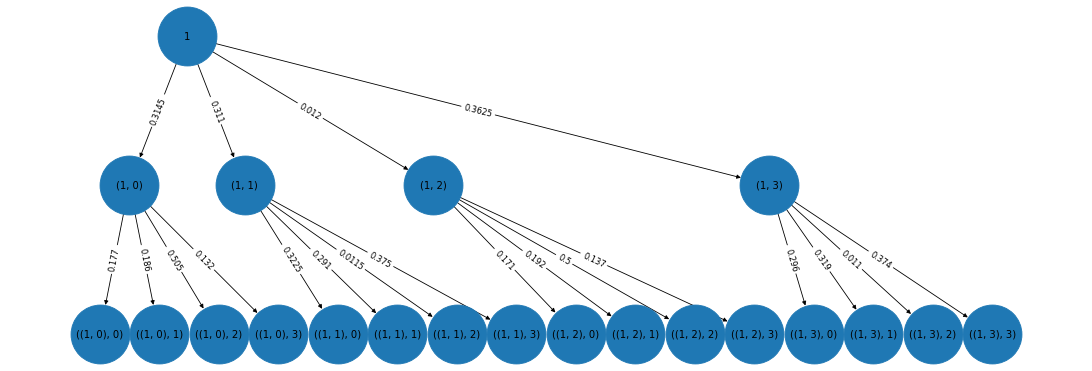

In [30]:
    
sampler = Sampler()
job = sampler.run(circuit_list,shots = 2000)
result = job.result()
df = pd.DataFrame(list(enumerate(result.quasi_dists,1)))
df.set_index(0, inplace=True)

df = df[1].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 1, 1: "one"})
df[1] = df[1].astype(int)
df.set_index(1, append=True, inplace=True)

tree = df.loc[[1]]
tree["weight"] = tree["one"]
tree = tree["weight"].to_frame()
tree["leaf"] = tree.index.get_level_values(1)
tree.index = tree.index.to_flat_index()
dft = tree[["weight","leaf"]]


for i in range(2,3):
    dft = dft[["weight","leaf"]]
    tree_list = []

    for test in list(dft.leaf.to_list()):
        circuit_sampler = QuantumCircuit(qreg_q)
        circuit_sampler.initialize(test)
        circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
        circuit_sampler.measure_all()
        tree_list += [circuit_sampler]

    job_tree = sampler.run(tree_list,shots = 2000).result()

    dft["weight"] = pd.DataFrame(list(enumerate(job_tree.quasi_dists,1)))[1].values

    dft = dft["weight"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: i, 1: "weight"})

    dft[i] = dft[i].astype(int)
    dft.set_index(i, append=True, inplace=True)
    dft["leaf"] = dft.index.get_level_values(1)
    dft.index = dft.index.to_flat_index()
    tree = pd.concat([tree,dft])
    
tree["leaf"] = tree.index.values

tree["parent"] = pd.Series(list(zip(*tree.leaf))[0]).values


tree_graph = nx.from_pandas_edgelist(tree, source='parent', target='leaf',edge_attr=["weight"],  create_using=nx.DiGraph)


fig = plt.figure(1, figsize=(18, 6), dpi=60)
tree_layout_graph = nx.nx_agraph.graphviz_layout(tree_graph, prog="dot")

labels = {e: tree_graph.get_edge_data(e[0], e[1])["weight"] for e in tree_graph.edges()}
nx.draw(tree_graph,tree_layout_graph, with_labels = True, node_size=5000)
nx.draw_networkx_edge_labels(tree_graph, pos=tree_layout_graph, edge_labels=labels)
plt.show()


In the network diagram you can see the edge weights are approximately:

0 -> 0 : 0.18  | 0 -> 1 : 0.20  | 0 -> 2 : 0.50  | 0 -> 3 : 0.12

1 -> 0 : 0.33  | 1 -> 1 : 0.33  | 1 -> 2 : 0.01  | 1 -> 3 : 0.33

2 -> 0 : 0.18  | 2 -> 1 : 0.18  | 2 -> 2 : 0.50  | 2 -> 3 : 0.14

3 -> 0 : 0.33  | 3 -> 1 : 0.33  | 3 -> 2 : 0.01  | 3 -> 3 : 0.33

In [31]:


circuit_list_two = []

for test in list(df.index.get_level_values(1)):
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list_two += [circuit_sampler]
    
job_two = sampler.run(circuit_list_two,shots = 2000).result()

df["two"] = pd.DataFrame(list(enumerate(job_two.quasi_dists,1)))[1].values

dft = df["two"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 2, 1: "two"})
df = df["one"].to_frame().join(dft)
df[2] = df[2].astype(int)
df.set_index(2, append=True, inplace=True)

circuit_list_three = []

for test in list(df.index.get_level_values(2)):
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list_three += [circuit_sampler]
    
job_three = sampler.run(circuit_list_three,shots = 2000).result()

df["three"] = pd.DataFrame(list(enumerate(job_three.quasi_dists,1)))[1].values


dft = df["three"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 3, 1: "three"})
df = df[["one","two"]].join(dft)
df[3] = df[3].astype(int)
df.set_index(3, append=True, inplace=True)

df["probs"] = (df["one"]) + (df["two"]) + (df["three"])

df.groupby(level=[0])["probs"].nlargest(1).droplevel([0,1,2]).to_frame().T

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
3,2,2,2,6,6,6,6,10,10,10,...,22,22,26,26,26,26,30,30,30,30
probs,1.2765,1.4535,1.301,1.4245,1.2915,1.4655,1.3005,1.458,1.2935,1.471,...,1.4635,1.2665,1.456,1.272,1.4385,1.3095,1.4945,1.322,1.424,1.309


When traversing the network with a depth of 3 the path with the highest sum of edge weights will always be the input's largest closest odd multiple of two. 

In the table above the first row is inputs and the second is outputs. The bottom row is the highest summed edge weight.

The verbiage "[When inputs] are odd convert them into even numbers" may indicate that this solution is also invalid because some even inputs are being changed.

